# Analisis del modelo entrenado

He entrenado el modelo en el HPMOON con los datos de PSM, de la misma forma que indicaba el paper, practicamente calcado el entrenamiento, ahora me falta hacer la inferencia e investigar como funciona el modelo. 

No creo que pueda hacer inferencia en local, pero lo intentaré.



In [6]:
#tenemos que agregar al sys path el directorio
import sys
AssDis_path="/home/arturo/Documents/MasterCD/TFM/codigo/otros_repos/Anomaly-Transformer_oficial"
sys.path.append(AssDis_path)

In [7]:

import numpy as np 
import torch
import matplotlib.pyplot as plt 
import time
from torch import nn

import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import collections
import numbers
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

from model.AnomalyTransformer import AnomalyTransformer


In [8]:
BASE_dir="/home/arturo/Documents/MasterCD/TFM/codigo/TFM/1-AnomalyTranformer_MIO/ejecucion_remota"
dataset_name="PSM"

datapath=f"{BASE_dir}/data/{dataset_name}"
model_save_path=f"{BASE_dir}/results_y_models/1-PSM_models"

if (not os.path.exists(model_save_path)):
    print(f"creado {model_save_path}")
    os.mkdir(model_save_path)



In [9]:

#funcion para ocntar los parametros del modelo 
def count_parameters(model):
    total=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total}")
    return total


In [10]:

class PSMSegLoader(object): ##y esto no deberia heredar de dataset?
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()
        data = pd.read_csv(data_path + '/train.csv')
        data = data.values[:100, 1:]

        data = np.nan_to_num(data)

        self.scaler.fit(data)
        data = self.scaler.transform(data)
        test_data = pd.read_csv(data_path + '/test.csv')

        test_data = test_data.values[:2000, 1:]
        test_data = np.nan_to_num(test_data)

        self.test = self.scaler.transform(test_data)

        self.train = data
        self.val = self.test

        self.test_labels = pd.read_csv(data_path + '/test_label.csv').values[:, 1:] ## y los labels de train ?

        print("test:", self.test.shape)
        print("train:", self.train.shape)

    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'val'):
            return (self.val.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'test'):
            return (self.test.shape[0] - self.win_size) // self.step + 1
        else:
            return (self.test.shape[0] - self.win_size) // self.win_size + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'val'):
            return np.float32(self.val[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'test'):
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])
        else:
            return np.float32(self.test[
                              index // self.step * self.win_size:index // self.step * self.win_size + self.win_size]), np.float32(
                self.test_labels[index // self.step * self.win_size:index // self.step * self.win_size + self.win_size])



def get_loader_segment(data_path, batch_size, win_size=100, step=100, mode='train', dataset='KDD'):
    # if (dataset == 'SMD'):
    #     dataset = SMDSegLoader(data_path, win_size, step, mode)
    # elif (dataset == 'MSL'):
    #     dataset = MSLSegLoader(data_path, win_size, 1, mode)
    # elif (dataset == 'SMAP'):
    #     dataset = SMAPSegLoader(data_path, win_size, 1, mode)
    # elif (dataset == 'PSM'):

    dataset = PSMSegLoader(data_path, win_size, 1, mode)

    shuffle = False
    if mode == 'train':
        shuffle = True

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=0)
    return data_loader



class EarlyStopping:
    def __init__(self, patience=7, verbose=False, dataset_name='', delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_score2 = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_loss2_min = np.Inf
        self.delta = delta
        self.dataset = dataset_name

    def __call__(self, val_loss, val_loss2, model, path):
        score = -val_loss
        score2 = -val_loss2
        if self.best_score is None:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
        elif score < self.best_score + self.delta or score2 < self.best_score2 + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, val_loss2, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), os.path.join(path, str(self.dataset) + '_checkpoint.pth'))
        self.val_loss_min = val_loss
        self.val_loss2_min = val_loss2



#para el modelo en sí

def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)


def adjust_learning_rate(optimizer, epoch, lr_):
    lr_adjust = {epoch: lr_ * (0.5 ** ((epoch - 1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))
        


In [11]:
test_loader = get_loader_segment(datapath, batch_size=16, win_size=100,mode='test',dataset=dataset_name)


test: (2000, 25)
train: (100, 25)


In [12]:
a=next(iter(test_loader))

In [13]:
print(a[0].shape,a[1].shape)

torch.Size([16, 100, 25]) torch.Size([16, 100, 1])


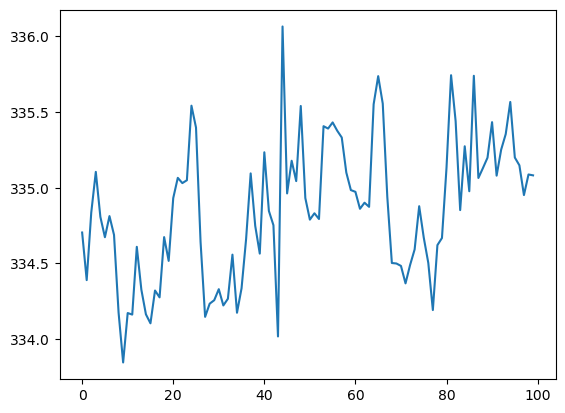

In [14]:
plt.plot(a[0][1,:,1])

In [17]:
model=torch.load("./ejecucion_remota/results_y_models/1-PSM_models/PSM_checkpoint.pth",map_location=torch.device('cpu'))

In [68]:
win_size=100

model=AnomalyTransformer(win_size=win_size, enc_in=25, c_out=25, e_layers=3, d_model=512, n_heads=8)
model.load_state_dict(torch.load("./ejecucion_remota/results_y_models/1-PSM_models/PSM_checkpoint.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
y_pred=model(a[0])

In [35]:
y_pred[1][0].shape

torch.Size([16, 8, 100, 100])

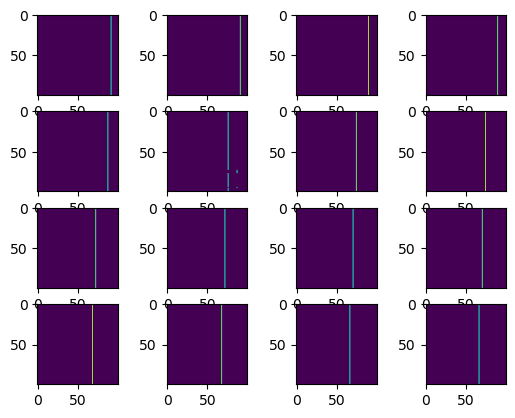

In [43]:
for i in range(4**2):
    plt.subplot(4,4,i+1)
    plt.imshow(y_pred[1][0][i,6].detach().numpy())

Vamos a ir poco a poco sacando lo necesario para evaluar al modelo.  


In [46]:
x_test,y_test=next(iter(test_loader))
print(x_test.shape,y_test.shape)
output, series, prior, sigmas = model(x_test)

torch.Size([16, 100, 25]) torch.Size([16, 100, 1])


In [57]:
output[0][:,9]

tensor([0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563, 0.6563,
        0.6563], grad_fn=<SelectBackward0>)

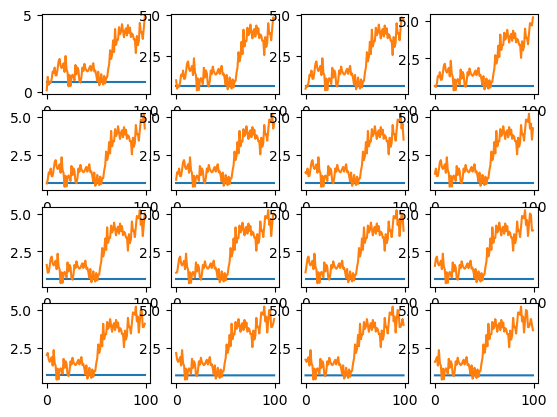

In [69]:
for i in range(4**2):
    plt.subplot(4,4,i+1)
    plt.plot(output[i][:,9].detach().numpy())
    plt.plot(x_test[i][:,9].detach().numpy())

In [72]:
criterion =nn.MSELoss(reduction="none") #nn.MSELoss(reduce=False) #esto se hace para devolver el valor de loss por batch. 
temperature=50
loss = torch.mean(criterion(x_test, output), dim=-1)
print(loss.shape)
series_loss = 0.0
prior_loss = 0.0
for u in range(len(prior)):
    if u == 0:
        series_loss = my_kl_loss(series[u], (
                prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)).detach()) * temperature #ojo que añade la temperatura, qeu no se
        prior_loss = my_kl_loss(
            (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                    win_size)),
            series[u].detach()) * temperature
    else: # lo hacemos en dos por las formas de los tensores ¿pero que cambia con respecto a antes?
        series_loss += my_kl_loss(series[u], (
                prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)).detach()) * temperature
        prior_loss += my_kl_loss(
            (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                    win_size)),
            series[u].detach()) * temperature
##no falta que divida por L ??
metric = torch.softmax((-series_loss - prior_loss), dim=-1) #son iguales no ?
cri = metric * loss
cri = cri.detach().cpu().numpy()

torch.Size([16, 100])


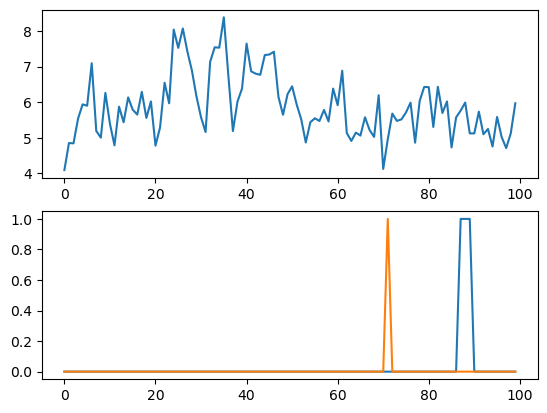

In [92]:
n=2
plt.subplot(2,1,1)
plt.plot(x_test[n,:,15].squeeze().detach())
plt.subplot(2,1,2)
plt.plot(y_test[n].squeeze().detach())
plt.plot(cri[n]/max(cri[n]))

In [114]:
test_loader = get_loader_segment(datapath, batch_size=16, win_size=100,mode='test',dataset=dataset_name)

model.eval()
attens_energy = []
test_labels = []

for i, (input_data, labels) in enumerate(test_loader):
    input = input_data.float()
    output, series, prior, _ = model(input)

    loss = torch.mean(criterion(input, output), dim=-1)

    series_loss = 0.0
    prior_loss = 0.0
    for u in range(len(prior)):
        if u == 0:
            series_loss = my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
            prior_loss = my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach()) * temperature
        else:
            series_loss += my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach()) * temperature
            prior_loss += my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach()) * temperature
    ##no falta que divida por L ??
    # Metric
    metric = torch.softmax((-series_loss - prior_loss), dim=-1)
    cri = metric * loss
    cri = cri.detach().cpu().numpy()
    attens_energy.append(cri)
    test_labels.append(labels)


test: (2000, 25)
train: (100, 25)


In [116]:
attens_energy_2 = np.concatenate(attens_energy, axis=0).reshape(-1)
test_labels_2 = np.concatenate(test_labels, axis=0).reshape(-1)
test_energy_3 = np.array(attens_energy_2)
test_labels_3 = np.array(test_labels_2)

In [131]:
#el threshold aunque no este bien, lo vamos a calcular sobre test
thresh = np.percentile(test_energy_3, 100 - 4)
thresh

6.1019939669161495e-33

In [132]:
pred = (test_energy_3 > thresh).astype(int)
print(pred)
gt = test_labels_3.astype(int)
print(gt)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


ya tenemos unas posibles anomalias, ahora habria que evaluarlas

In [133]:
print("pred:   ", pred.shape)
print("gt:     ", gt.shape)

# detection adjustment
anomaly_state = False
for i in range(len(gt)):
    if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
        anomaly_state = True
        for j in range(i, 0, -1):
            if gt[j] == 0:
                break
            else:
                if pred[j] == 0:
                    pred[j] = 1
        for j in range(i, len(gt)):
            if gt[j] == 0:
                break
            else:
                if pred[j] == 0:
                    pred[j] = 1
    elif gt[i] == 0:
        anomaly_state = False
    if anomaly_state:
        pred[i] = 1

pred = np.array(pred)
gt = np.array(gt)
print("pred: ", pred.shape)
print("gt:   ", gt.shape)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(gt, pred)
precision, recall, f_score, support = precision_recall_fscore_support(gt, pred,
                                                                        average='binary')
print(
    "Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
        accuracy, precision,
        recall, f_score))

print( accuracy, precision, recall, f_score)

pred:    (190100,)
gt:      (190100,)
pred:  (190100,)
gt:    (190100,)
Accuracy : 0.9592, Precision : 0.0117, Recall : 0.3297, F-score : 0.0227 
0.9591951604418727 0.01174321503131524 0.32967032967032966 0.022678593927176513
